In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/w266')

In [2]:
import re
import json
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
# import tensorflow_datasets as tfds

from transformers import AutoTokenizer,TFAutoModel,TFAutoModelForSequenceClassification
from transformers import logging
logging.set_verbosity_error()  # skip warnings

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay

In [3]:
data=pd.read_csv('reuters_with_prob_ret_2_cut.csv',engine='python',parse_dates=True).dropna()
data.shape

(30650, 12)

In [4]:
data['Time']=pd.to_datetime(data['Time'])

In [5]:
data.tail()

,Headlines,Time,Description,prob_netrual,prob_positive,prob_negative,sent,prob_diff,stock,oil,bond,dollar
30645,Exclusive: Thyssenkrupp to explore further opt...,2020-07-17,Thyssenkrupp is seeking new ways to strengthe...,0.000008,0.999992,5.806786e-07,2,0.999991,1.0,0.0,0.0,0.0
30646,"UBS, Morgan Stanley expected to lead Vodafone ...",2020-07-17,UBS and Morgan Stanley are expected to organ...,0.974843,0.025146,1.102120e-05,1,0.025135,1.0,0.0,0.0,0.0
30647,As big U.S. banks let customers delay payments...,2020-07-17,Major U.S. bank executives this week said they...,0.731482,0.002488,2.660300e-01,1,-0.263542,1.0,0.0,0.0,0.0
30648,End of the jumbo: British Airways retires 747 ...,2020-07-17,"British Airways, the world's largest operator ...",0.987032,0.000336,1.263200e-02,1,-0.012296,1.0,0.0,0.0,0.0
30649,U.S. Republicans seek liability protections as...,2020-07-17,A battle in the U.S. Congress over a new coron...,0.690913,0.003156,3.059306e-01,1,-0.302774,1.0,0.0,0.0,0.0


In [ ]:
raw=pd.read_csv('reuters_headlines.csv',engine='python')

In [11]:
p=pd.read_csv('price_of_major_assets.csv',index_col=0,parse_dates=True).drop('gold',axis=1)

In [31]:
r=np.log(p.ffill()).diff()
r_cut=r.copy()
for c in r.columns:
  r_cut[c]=pd.qcut(r[c],q=[0,0.5,1],labels=False)

In [52]:
r.corr()

,stock,oil,bond,dollar
stock,1.000000,0.338771,-0.177110,-0.201887
oil,0.338771,1.000000,-0.172606,-0.047461
bond,-0.177110,-0.172606,1.000000,-0.271234
dollar,-0.201887,-0.047461,-0.271234,1.000000


In [ ]:
r.drop('gold',axis=1,inplace=True)

In [32]:
combined=data.merge(r_cut.reset_index(),left_on='Time',right_on='Date')

In [33]:
combined.drop('Date',axis=1,inplace=True)

In [ ]:
combined.corr().loc[r.columns]

<ipython-input-19-c633f5ed7172>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  combined.corr().loc[r.columns]


,prob_netrual,prob_positive,prob_negative,sent,prob_diff,stock,oil,bond,dollar
stock,-0.008458,-0.009086,0.016134,-0.015159,-0.015971,1.000000,0.307396,-0.413086,-0.038384
oil,-0.010381,0.008131,0.004550,0.001711,0.001288,0.307396,1.000000,-0.228926,-0.031530
bond,0.005053,0.002804,-0.007563,0.007003,0.006698,-0.413086,-0.228926,1.000000,-0.106275
dollar,0.001519,0.000690,-0.002152,0.003447,0.001848,-0.038384,-0.031530,-0.106275,1.000000


In [23]:
data_mean=data.groupby('Time')[['prob_netrual', 'prob_positive',
       'prob_negative', 'sent', 'prob_diff']].mean()

In [24]:
data_mean['sent_mean']=np.argmax(data_mean[['prob_negative','prob_netrual', 'prob_positive']].to_numpy(),axis=1)

In [25]:
combined_mean=pd.concat([data_mean.sort_index(),r_cut],axis=1).dropna()

In [46]:
daily_headline=data.groupby('Time')['Headlines'].agg(lambda x: ' '.join(x))

In [55]:
combined.sort_values('Time').to_csv('reuters_with_prob_ret_2_cut.csv',index=False)

<Axes: >

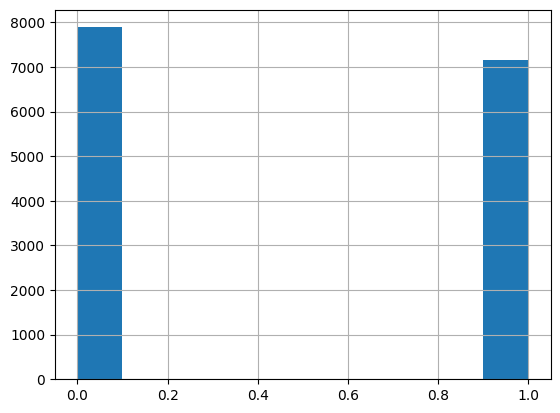

In [39]:
combined[combined['sent']!=1]['oil'].hist()

<Axes: >

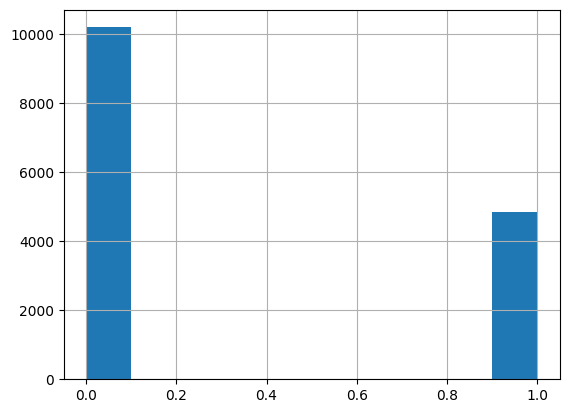

In [40]:
combined[combined['sent']!=1]['sent'].replace({2:1}).hist()

In [49]:
combined.tail()

,Headlines,Time,Description,prob_netrual,prob_positive,prob_negative,sent,prob_diff,stock,oil,bond,dollar
30645,Malaysia says never hired British data firm at...,2018-03-20,The Malaysian government and the ruling party ...,0.019213,0.000254,0.980533,0,-0.980279,1.0,1.0,0.0,1.0
30646,Prosecutors search Volkswagen headquarters in ...,2018-03-20,German prosecutors said on Tuesday they had se...,0.689996,0.000176,0.309828,1,-0.309652,1.0,1.0,0.0,1.0
30647,McDonald's sets greenhouse gas reduction targets,2018-03-20,McDonald's Corp on Tuesday announced an approv...,0.993850,0.006047,0.000104,1,0.005943,1.0,1.0,0.0,1.0
30648,Pratt & Whitney to deliver spare A320neo engin...,2018-03-20,Pratt & Whitney will soon begin deliveries of ...,0.860934,0.000101,0.138965,1,-0.138865,1.0,1.0,0.0,1.0
30649,UK will always consider ways to improve data l...,2018-03-20,Britain will consider any suggestions to give ...,0.005661,0.000053,0.994286,0,-0.994233,1.0,1.0,0.0,1.0


In [71]:
print(classification_report(combined[combined['sent']!=1]['stock'],combined[combined['sent']!=1]['sent'].replace({2:1})))

              precision    recall  f1-score   support

         0.0       0.50      0.71      0.59      7176
         1.0       0.58      0.36      0.44      7873

    accuracy                           0.53     15049
   macro avg       0.54      0.54      0.52     15049
weighted avg       0.54      0.53      0.51     15049



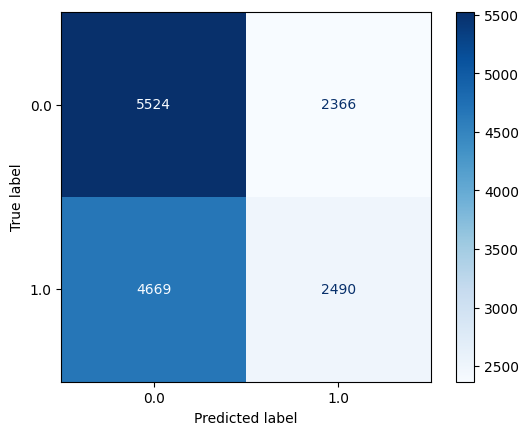

In [68]:
ConfusionMatrixDisplay.from_predictions(combined[combined['sent']!=1]['oil'],combined[combined['sent']!=1]['sent'].replace({2:1}),cmap=plt.cm.Blues,
        )

In [59]:
disp

<Axes: xlabel='Date'>

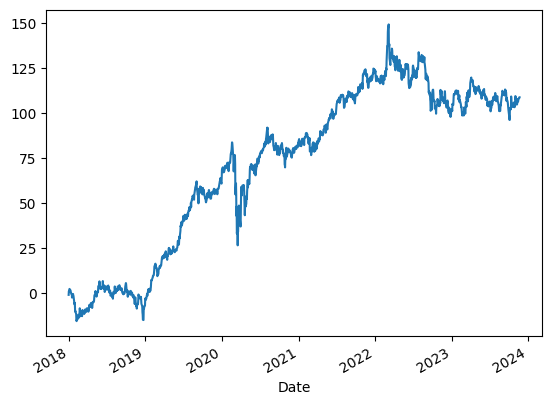

In [ ]:
(r/r.std()).sum(axis=1).cumsum().plot()

In [ ]:
data.groupby('Time')['Description'].count().describe()

count    852.000000
mean      38.462441
std       23.269529
min        1.000000
25%       14.000000
50%       42.000000
75%       55.000000
max      126.000000
Name: Description, dtype: float64

In [ ]:
data['Time']=pd.to_datetime(data['Time'])

In [ ]:
data.to_csv('combined_r_now_with_prob.csv',index=False)

In [ ]:
data.shape

(15366, 10)

In [15]:
def count_words(text):
    words = text.split()
    return len(words)

data['Description'].apply(count_words).describe()

count    30650.000000
mean        34.399184
std          6.731292
min          7.000000
25%         30.000000
50%         35.000000
75%         39.000000
max         88.000000
Name: Description, dtype: float64

In [ ]:
data['r_now_cut']=pd.qcut(data['r_now'],q=[0,0.33,0.66,1],labels=False)

In [ ]:
data['r_sign']=np.sign(data['r_now'])

In [8]:
data['Time'].unique().shape

(609,)

In [9]:
sampled_data = data.sample(n=data.shape[0], random_state=66)

train_size=round(sampled_data.shape[0]*0.8)
train_size

24520

In [10]:
sampled_data.columns

Index(['Headlines', 'Time', 'Description', 'prob_netrual', 'prob_positive',
       'prob_negative', 'sent', 'prob_diff', 'stock', 'oil', 'bond', 'dollar'],
      dtype='object')

In [ ]:
texts = sampled_data["Description"]
labels = sampled_data[['stock', 'oil', 'bond', 'dollar']]

In [ ]:
train_x=data['Description'].to_list()

In [11]:
train=sampled_data[:train_size]
test=sampled_data[train_size:]

In [12]:
train_x=train['Description'].to_list()
test_x=test['Description'].to_list()
train_y=train['stock'].to_numpy()#.reshape((-1,4,1))
test_y=test['stock'].to_numpy()#.reshape((-1,4,1))

In [13]:
train_y

array([0., 1., 0., ..., 1., 1., 0.])

In [14]:
checkpoint = 'yiyanghkust/finbert-tone'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)
model_class = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

c:\Users\mingxi.liu\py310\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mingxi.liu\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [16]:
MAX_SEQUENCE_LENGTH=100

In [17]:
train_tokenized = tokenizer(train_x,max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
test_tokenized = tokenizer(test_x,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

In [18]:
train_tokenized['input_ids']

<tf.Tensor: shape=(24520, 100), dtype=int32, numpy=
array([[   3,    6,  245, ...,    0,    0,    0],
       [   3, 1308, 5674, ...,    0,    0,    0],
       [   3,  321,  311, ...,    0,    0,    0],
       ...,
       [   3,    6, 2176, ...,    0,    0,    0],
       [   3, 2647,  387, ...,    0,    0,    0],
       [   3, 1789, 5674, ...,    0,    0,    0]])>

In [ ]:
output_direct=model_class(**train_tokenized)

In [ ]:
output=model_class.predict([train_tokenized['input_ids'],train_tokenized['attention_mask']])

1025/1025 [==============================] - 220s 207ms/step


In [ ]:
probs = tf.nn.softmax(output['logits'], axis=-1)

In [ ]:
probs

<tf.Tensor: shape=(32770, 3), dtype=float32, numpy=
array([[0.32138598, 0.33079037, 0.34782362],
       [0.37014773, 0.31818977, 0.31166244],
       [0.37202102, 0.30887794, 0.319101  ],
       ...,
       [0.3266377 , 0.35051024, 0.32285205],
       [0.32965973, 0.32298368, 0.3473566 ],
       [0.3339731 , 0.33251825, 0.3335086 ]], dtype=float32)>

In [ ]:
data[['prob_netrual','prob_positive','prob_negative']]=probs

In [ ]:
data.tail()

,Headlines,Time,Description,prob_netrual,prob_positive,prob_negative,sent,prob_diff
32765,Malaysia says never hired British data firm at...,2018-03-20,The Malaysian government and the ruling party ...,0.019213,0.000254,0.980533,0,-0.980279
32766,Prosecutors search Volkswagen headquarters in ...,2018-03-20,German prosecutors said on Tuesday they had se...,0.689996,0.000176,0.309828,1,-0.309652
32767,McDonald's sets greenhouse gas reduction targets,2018-03-20,McDonald's Corp on Tuesday announced an approv...,0.993850,0.006047,0.000104,1,0.005943
32768,Pratt & Whitney to deliver spare A320neo engin...,2018-03-20,Pratt & Whitney will soon begin deliveries of ...,0.860934,0.000101,0.138965,1,-0.138865
32769,UK will always consider ways to improve data l...,2018-03-20,Britain will consider any suggestions to give ...,0.005661,0.000053,0.994286,0,-0.994233


In [ ]:
data['sent']=np.argmax(probs,axis=1)

In [ ]:
data.columns=['Headlines', 'Time', 'Description', 'Date', 'stock',
       'oil', 'bond', 'dollar', 'gold', 'prob_netrual', 'prob_positive', 'prob_negative',
       'sent']

In [ ]:
data['sent'].replace({2:0,0:1,1:2},inplace=True)

In [ ]:
data['prob_diff']=data['prob_positive']-data['prob_negative']

In [ ]:
combined.drop(['Headlines', 'Time', 'Description'],axis=1).corr()

,prob_netrual,prob_positive,prob_negative,sent,prob_diff,stock_x,oil_x,bond_x,dollar_x,gold_x,stock_y,oil_y,bond_y,dollar_y,gold_y
prob_netrual,1.000000,-0.444925,-0.705908,0.246013,0.242449,0.002366,0.017786,-0.004841,-0.011473,-0.004704,-0.012412,-0.014203,0.004593,-0.007157,0.001965
prob_positive,-0.444925,1.000000,-0.320257,0.741410,0.760976,0.012048,0.006419,-0.001916,-0.005263,0.006473,0.004942,0.015827,0.002604,-0.004609,-0.002244
prob_negative,-0.705908,-0.320257,1.000000,-0.846612,-0.858317,-0.012032,-0.023891,0.006635,0.016298,-0.000144,0.009221,0.002506,-0.006918,0.011216,-0.000304
sent,0.246013,0.741410,-0.846612,1.000000,0.981386,0.015189,0.019836,-0.008635,-0.011352,-0.000365,-0.004676,0.005146,0.006475,-0.007427,-0.002688
prob_diff,0.242449,0.760976,-0.858317,0.981386,1.000000,0.014766,0.019839,-0.005582,-0.014012,0.003604,-0.003638,0.006856,0.006148,-0.010178,-0.001007
stock_x,0.002366,0.012048,-0.012032,0.015189,0.014766,1.000000,0.490033,-0.578678,0.015729,0.082329,0.307543,0.071873,-0.155157,0.078338,0.086404
oil_x,0.017786,0.006419,-0.023891,0.019836,0.019839,0.490033,1.000000,-0.303007,0.089079,0.061076,0.161314,0.009299,-0.090977,-0.019023,0.069041
bond_x,-0.004841,-0.001916,0.006635,-0.008635,-0.005582,-0.578678,-0.303007,1.000000,-0.238803,0.311851,-0.101568,-0.064133,0.039935,-0.088532,0.037524
dollar_x,-0.011473,-0.005263,0.016298,-0.011352,-0.014012,0.015729,0.089079,-0.238803,1.000000,-0.380952,-0.118457,0.043940,0.098142,0.094402,0.056234
gold_x,-0.004704,0.006473,-0.000144,-0.000365,0.003604,0.082329,0.061076,0.311851,-0.380952,1.000000,0.213608,0.046616,-0.068949,-0.061712,0.024431


In [ ]:
data.to_csv('reuters_news_with_prob.csv',index=False)

# model on logits

In [ ]:
def create_model_using_logits(model_class,learning_rate=0.00005,num_assets=4,num_class=3):
  model_class.trainable=False
  input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')
  input={'input_ids': input_ids, 'attention_mask': attention_mask}
  logits_layer=model_class(input)['logits']
  # hidden_layer=tf.keras.layers.Dense(3)(logits_layer)
  # hidden_layer=tf.keras.layers.Dense(3)(hidden_layer)
  # hidden_layer=tf.keras.layers.Dense(3)(hidden_layer)

  output_layers = []
  for _ in range(num_assets):
      output_layer = tf.keras.layers.Dense(num_class, activation='softmax')(logits_layer)
      output_layers.append(output_layer)

  classification_model = tf.keras.Model(inputs=[input], outputs=output_layers)
  classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=['sparse_categorical_crossentropy']*4,
                                 metrics=['sparse_categorical_accuracy'])
  return classification_model


In [ ]:
model_using_logits=create_model_using_logits(model_class)

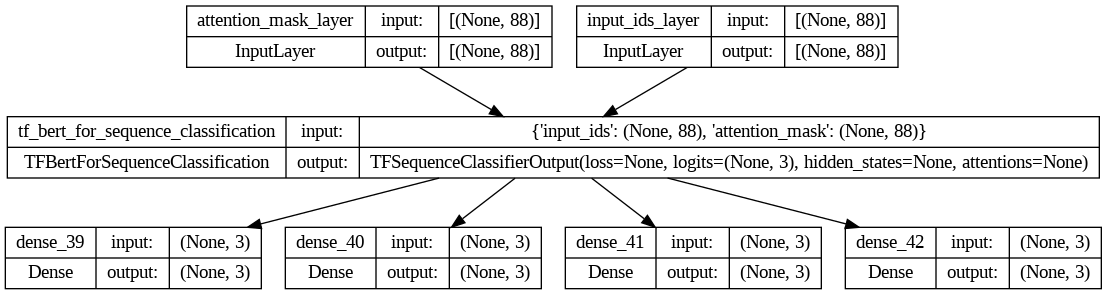

In [ ]:
tf.keras.utils.plot_model(model_using_logits,show_shapes=True)

In [ ]:
output=model_using_logits.predict([train_tokenized['input_ids'][:5],train_tokenized['attention_mask'][:5]])

1/1 [==============================] - 2s 2s/step


In [ ]:
output

[array([[9.7377974e-01, 2.4439772e-05, 2.6195776e-02],
        [9.3912435e-01, 7.3496054e-04, 6.0140662e-02],
        [9.8612809e-01, 5.3413646e-06, 1.3866587e-02],
        [9.3912435e-01, 7.3496054e-04, 6.0140662e-02],
        [9.3912435e-01, 7.3496054e-04, 6.0140662e-02]], dtype=float32),
 array([[9.8979735e-01, 5.9071263e-05, 1.0143516e-02],
        [9.6986830e-01, 3.6835665e-04, 2.9763410e-02],
        [9.9455053e-01, 5.1577510e-05, 5.3978711e-03],
        [9.6986830e-01, 3.6835662e-04, 2.9763410e-02],
        [9.6986830e-01, 3.6835662e-04, 2.9763410e-02]], dtype=float32),
 array([[2.3251241e-02, 1.1342442e-04, 9.7663534e-01],
        [6.5161280e-02, 1.1504451e-03, 9.3368822e-01],
        [1.3220569e-02, 6.5058310e-05, 9.8671442e-01],
        [6.5161280e-02, 1.1504451e-03, 9.3368822e-01],
        [6.5161280e-02, 1.1504451e-03, 9.3368822e-01]], dtype=float32),
 array([[9.6822417e-01, 3.1518813e-02, 2.5704008e-04],
        [9.5344907e-01, 4.4962235e-02, 1.5887241e-03],
        [9.784

In [ ]:
hist_model_using_logits=model_using_logits.fit(
    [train_tokenized['input_ids'],train_tokenized['attention_mask']],
    [train_y[i].to_numpy() for i in train_y.columns],
    validation_split=0.2,
    batch_size=32,
    epochs=2
)

Epoch 1/2
  8/613 [..............................] - ETA: 1:48:28 - loss: 9.3335 - dense_39_loss: 3.1601 - dense_40_loss: 1.9230 - dense_41_loss: 1.2325 - dense_42_loss: 3.0179 - dense_39_sparse_categorical_accuracy: 0.3867 - dense_40_sparse_categorical_accuracy: 0.3086 - dense_41_sparse_categorical_accuracy: 0.3906 - dense_42_sparse_categorical_accuracy: 0.2969

KeyboardInterrupt: ignored

In [ ]:
train_y.shape

(24520, 4, 1)

In [ ]:
model_using_logits_predict=model_using_logits.predict([test_tokenized['input_ids'],test_tokenized['attention_mask']])

213/213 [==============================] - 31s 112ms/step


In [ ]:
model_using_logits_predict[-5:]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
predict=np.argmax(model_using_logits_predict,axis=1)

In [ ]:
output=pd.DataFrame([test_x,test_y,predict])

In [ ]:
output=output.T
output.columns=['tweets','label','predict']

<Axes: >

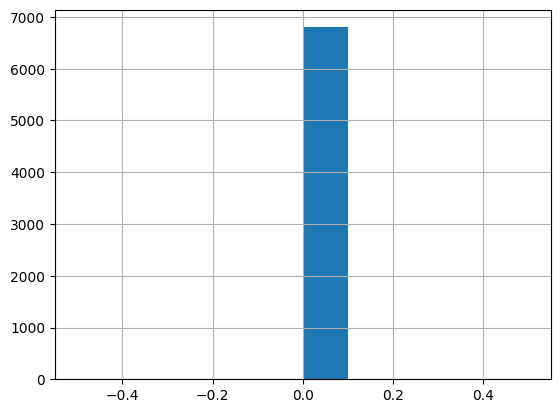

In [ ]:
output['predict'].hist()

In [ ]:
output.to_csv('output_using_logits.csv',index=False)

In [ ]:
print(classification_report(test_y,predict))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3398
           1       0.00      0.00      0.00      3327
           2       0.34      1.00      0.50      3426

    accuracy                           0.34     10151
   macro avg       0.11      0.33      0.17     10151
weighted avg       0.11      0.34      0.17     10151



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(test_y,sampled_data['sense_fin'][train_size:]))

              precision    recall  f1-score   support

           0       0.38      0.11      0.17      3398
           1       0.33      0.60      0.43      3327
           2       0.34      0.31      0.33      3426

    accuracy                           0.34     10151
   macro avg       0.35      0.34      0.31     10151
weighted avg       0.35      0.34      0.31     10151



In [ ]:
np.random.randint(0,3,size=len(sampled_data)-train_size)

array([0, 1, 2, ..., 0, 1, 1])

In [ ]:
print(classification_report(test_y,np.random.randint(0,3,size=len(sampled_data)-train_size)))

              precision    recall  f1-score   support

           0       0.33      0.33      0.33      3398
           1       0.31      0.31      0.31      3327
           2       0.34      0.34      0.34      3426

    accuracy                           0.33     10151
   macro avg       0.33      0.33      0.33     10151
weighted avg       0.33      0.33      0.33     10151



In [19]:
# model on last pooler

In [20]:
def create_model_using_pooler(model,learning_rate=0.00005,num_class=3):
  model.trainable=False
  input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')
  input={'input_ids': input_ids, 'attention_mask': attention_mask}
  pooler_layer=model(input)['pooler_output']
  hidden_layer=tf.keras.layers.Dense(100,activation='relu')(pooler_layer)
  hidden_layer=tf.keras.layers.Dropout(0.3)(hidden_layer)
  classification=tf.keras.layers.Dense(num_class, activation='softmax',name='classification_layer')(hidden_layer)
  classification_model = tf.keras.Model(inputs=[input], outputs=[classification])
  classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')
  return classification_model


In [21]:
model_using_pooler=create_model_using_pooler(model,num_class=3)

tf.keras.utils.plot_model(model_using_pooler,show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [22]:

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [23]:

hist_model_using_pooler_new=model_using_pooler.fit(
    [train_tokenized['input_ids'],train_tokenized['attention_mask']],
    train_y,
    validation_split=0.2,
    batch_size=32,
    epochs=5,
    callbacks=early_stopping
)


Epoch 1/5
 18/613 [..............................] - ETA: 14:42 - loss: 1.1994 - accuracy: 0.3594

KeyboardInterrupt: 

In [ ]:

predicts=model_using_pooler.predict([test_tokenized['input_ids'],test_tokenized['attention_mask']])

predicts

result=sampled_data.iloc[train_size:].copy()

result[['prob_negative','prob_netrual','prob_positive']]=predicts

result['sent']=np.argmax(predicts,axis=1)
result['prob_diff']=result['prob_positive']-result['prob_negative']

result.tail()

result.corr()

result.corr()

print(classification_report(result['r_next_cut'],result['sent']))

from sklearn.metrics import confusion_matrix
confusion_matrix(result['r_next_cut'],result['sent'])

plt.plot(np.random.randint(-1, 2, size=200))

np.random.seed(42)
(result.reset_index()['r_trend_next']*np.random.randint(-1, 2, size=len(result))).cumsum().plot()

(result.reset_index()['r_trend_next']).cumsum().plot()

(result.reset_index()['r_trend_next']*(result.reset_index()['sent']-1)).cumsum().plot()

result.to_csv('result_by_pretrained_pooler.csv',index=False)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y,predict)

array([[   0, 1173, 2225],
       [   0, 1103, 2224],
       [   0, 1127, 2299]])